In [ ]:
!pip install -q --upgrade gspread
!pip install -q pandas
!pip install -q numpy
!pip install -q fuzzy_pandas
!pip install -q matplotlib

In [2]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials
import pandas as pd
import re
import numpy as np
import fuzzy_pandas as fpd
import matplotlib.pyplot as plt

Accessing Hubspot Import

In [19]:
gc = gspread.authorize(GoogleCredentials.get_application_default())
ss = gc.open_by_key('KEY')
hubspot_data = ss.worksheet('Hubspot Import')
hubsrows = hubspot_data.get_all_values()
df_hubs = pd.DataFrame.from_records(hubsrows[1:],columns=hubsrows[0])
df_hubs.head(5)

,Deal ID,Deal Name,Sales Strategy,Associated Company,Create Date,MQL Date,SQL Date,Opportunity Date,Close Date,SQL Value,Industry HB,Country HB
0,6916134982,BR: Mirum Agency & I-cherry,Outreach,mirumagency,2021-11-13 9:26,2021-09-28,2021-11-11,2021-11-11,2021-11-30 9:26,7800,Marketing and Advertising,Brasil
1,6912276917,RD: Edenorte Dominicana,Outreach,Edenorte Dominicana,2021-11-12 16:38,2021-11-12,,,2021-11-30 16:38,,Utilities,Republica Dominicana
2,6911045912,CO: Ideaware,Outreach,Ideaware,2021-11-12 14:35,2021-11-12,,,2021-11-30 14:35,,Information Technology and Services,Colombia
3,6908951636,mx: Improving - REFERRAL,Referral,Improving,2021-11-12 11:27,2021-11-12,2021-11-12,,2022-01-31 11:29,,Information Technology and Services,Mexico
4,6908766815,PE: TCS,Outreach,TCS,2021-11-12 10:51,2021-11-12,,,2022-02-28 10:52,5000,Information Technology and Services,Peru


Accessing Industries Index to map Head Industries as a new Column

In [21]:
ind_accesss = gc.open_by_key('1ASfhwu4pKwET5bz8coI59Bzpn05OuGoZBmWr12nQsyc')
ind_data = ind_accesss.worksheet('Industries')
indsrows = ind_data.get_all_values()
df_industries = pd.DataFrame.from_records(indsrows[1:],columns=indsrows[0])
display(df_industries.columns)
ind_dict = dict(zip(df_industries['Industry'],df_industries['Head Industry']))

Index(['#', 'Industry', 'Head Industry', '', '', 'HEAD INDUSTRIEs', '',
       'LATAM BDR', 'LATAM LGA', 'LATAM CLUSTER', 'BRASIL BDR', 'BRASIL LGA',
       'MX BDR', 'MX LGA', 'MX CLUSTER'],
      dtype='object')

In [22]:
df_hubs['Head Industry New'] = df_hubs["Industry HB"].map(ind_dict)
df_hubs.head(5)

,Deal ID,Deal Name,Sales Strategy,Associated Company,Create Date,MQL Date,SQL Date,Opportunity Date,Close Date,SQL Value,Industry HB,Country HB,Head Industry New
0,6916134982,BR: Mirum Agency & I-cherry,Outreach,mirumagency,2021-11-13 9:26,2021-09-28,2021-11-11,2021-11-11,2021-11-30 9:26,7800,Marketing and Advertising,Brasil,Professional Services
1,6912276917,RD: Edenorte Dominicana,Outreach,Edenorte Dominicana,2021-11-12 16:38,2021-11-12,,,2021-11-30 16:38,,Utilities,Republica Dominicana,Utilities
2,6911045912,CO: Ideaware,Outreach,Ideaware,2021-11-12 14:35,2021-11-12,,,2021-11-30 14:35,,Information Technology and Services,Colombia,Technology & Design
3,6908951636,mx: Improving - REFERRAL,Referral,Improving,2021-11-12 11:27,2021-11-12,2021-11-12,,2022-01-31 11:29,,Information Technology and Services,Mexico,Technology & Design
4,6908766815,PE: TCS,Outreach,TCS,2021-11-12 10:51,2021-11-12,,,2022-02-28 10:52,5000,Information Technology and Services,Peru,Technology & Design


Processing Dates and getting difference as an INT64

In [23]:
df_hubs['MQL Date'] = pd.to_datetime(df_hubs['MQL Date'])
df_hubs['SQL Date'] = pd.to_datetime(df_hubs['SQL Date'])
df_hubs['Opportunity Date'] = pd.to_datetime(df_hubs['Opportunity Date'])

In [24]:
df_hubs['MQL to SQL'] = (df_hubs['SQL Date'] - df_hubs['MQL Date']).dt.days
df_hubs['SQL to OPP'] = (df_hubs['Opportunity Date'] - df_hubs['SQL Date']).dt.days
df_hubs['MQL to Opportunity'] = (df_hubs['Opportunity Date'] - df_hubs['MQL Date']).dt.days
df_hubs.head(5)

,Deal ID,Deal Name,Sales Strategy,Associated Company,Create Date,MQL Date,SQL Date,Opportunity Date,Close Date,SQL Value,Industry HB,Country HB,Head Industry New,MQL to SQL,SQL to OPP,MQL to Opportunity
0,6916134982,BR: Mirum Agency & I-cherry,Outreach,mirumagency,2021-11-13 9:26,2021-09-28,2021-11-11,2021-11-11,2021-11-30 9:26,7800,Marketing and Advertising,Brasil,Professional Services,44.0,0.0,44.0
1,6912276917,RD: Edenorte Dominicana,Outreach,Edenorte Dominicana,2021-11-12 16:38,2021-11-12,NaT,NaT,2021-11-30 16:38,,Utilities,Republica Dominicana,Utilities,NaN,NaN,NaN
2,6911045912,CO: Ideaware,Outreach,Ideaware,2021-11-12 14:35,2021-11-12,NaT,NaT,2021-11-30 14:35,,Information Technology and Services,Colombia,Technology & Design,NaN,NaN,NaN
3,6908951636,mx: Improving - REFERRAL,Referral,Improving,2021-11-12 11:27,2021-11-12,2021-11-12,NaT,2022-01-31 11:29,,Information Technology and Services,Mexico,Technology & Design,0.0,NaN,NaN
4,6908766815,PE: TCS,Outreach,TCS,2021-11-12 10:51,2021-11-12,NaT,NaT,2022-02-28 10:52,5000,Information Technology and Services,Peru,Technology & Design,NaN,NaN,NaN


Preparing a Company Name Column Cleaned

In [25]:
df_hubs = df_hubs[df_hubs['Associated Company'].notna()]
df_hubs['Company'] = df_hubs['Associated Company'].str.lower().str.replace("[^a-z]\s"," ").str.replace(r"\b(company|corp|inc|a.c.|s.c.|mx|uy|br|co|)\b","").str.strip()
df_hubs.head(5)

,Deal ID,Deal Name,Sales Strategy,Associated Company,Create Date,MQL Date,SQL Date,Opportunity Date,Close Date,SQL Value,Industry HB,Country HB,Head Industry New,MQL to SQL,SQL to OPP,MQL to Opportunity,Company
0,6916134982,BR: Mirum Agency & I-cherry,Outreach,mirumagency,2021-11-13 9:26,2021-09-28,2021-11-11,2021-11-11,2021-11-30 9:26,7800,Marketing and Advertising,Brasil,Professional Services,44.0,0.0,44.0,mirumagency
1,6912276917,RD: Edenorte Dominicana,Outreach,Edenorte Dominicana,2021-11-12 16:38,2021-11-12,NaT,NaT,2021-11-30 16:38,,Utilities,Republica Dominicana,Utilities,NaN,NaN,NaN,edenorte dominicana
2,6911045912,CO: Ideaware,Outreach,Ideaware,2021-11-12 14:35,2021-11-12,NaT,NaT,2021-11-30 14:35,,Information Technology and Services,Colombia,Technology & Design,NaN,NaN,NaN,ideaware
3,6908951636,mx: Improving - REFERRAL,Referral,Improving,2021-11-12 11:27,2021-11-12,2021-11-12,NaT,2022-01-31 11:29,,Information Technology and Services,Mexico,Technology & Design,0.0,NaN,NaN,improving
4,6908766815,PE: TCS,Outreach,TCS,2021-11-12 10:51,2021-11-12,NaT,NaT,2022-02-28 10:52,5000,Information Technology and Services,Peru,Technology & Design,NaN,NaN,NaN,tcs


Importing Prospection Data from Prospects Tables

In [26]:
#Prospects 3
p3 = gc.open_by_key('12GRG8PNzKhkhVcuUcrLWXvVLxz58gdF_0zVy4vS24NU')
p3_data = p3.worksheet('All')
p3rows = p3_data.get_all_values()
df_p3 = pd.DataFrame.from_records(p3rows[1:],columns=p3rows[0])
#Prospects 2
p2 = gc.open_by_key('1XGrArQUq3O1uo7oYRPeKtPczGBkxd4v-yJtBdy_SZmQ')
p2_data = p2.worksheet('Sheet1')
p2rows = p2_data.get_all_values()
df_p2 = pd.DataFrame.from_records(p2rows[1:],columns=p2rows[0])
display(df_p2.columns)
#Joining them
prospects_df = pd.concat([df_p2,df_p3],axis=0)

Index(['Date', 'Company Name', 'Company ID', 'S-ID', 'LGA', 'Country', 'City',
       'Score Corp', 'Course 1', 'Course 2', 'website', 'First Name',
       'Last Name', 'Name', 'Score', 'Title', 'Email', 'LinkedIn Profile',
       'Phone', 'Industry', 'NeverBounce'],
      dtype='object')

Making a Dataset with 2021 Data and creating Head Industry Column

In [27]:
prospects_df['Date'] = pd.to_datetime(prospects_df['Date'])
neededcols = prospects_df[['Date','Company Name','Country','Industry']]
prosp_2021_all = neededcols[neededcols['Date'] > '31-12-2020']
prosp_2021_all['Head Industry'] = prosp_2021_all["Industry"].map(ind_dict)
prosp_2021 = prosp_2021_all.drop_duplicates(['Company Name','Date','Industry','Head Industry'])
prosp_2021.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Date,Company Name,Country,Industry,Head Industry
39727,2021-01-04,Pesco,Chile,Maritime,Transport and Logistics
39730,2021-01-04,Ventisqueros,Chile,Fishery,"Agriculture, Forestry and Fishing"
39733,2021-01-04,Productos Fernandez,Chile,Food & Beverages,Food and Beverage


In [28]:
prosp_2021['Company'] = prosp_2021['Company Name'].str.lower().str.replace("[^a-z]\s"," ").str.replace(r"\b(company|corp|inc|a.c.|s.c.|mx|uy|br|co|)\b","").str.strip()
prosp_2021.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Company Name,Country,Industry,Head Industry,Company
39727,2021-01-04,Pesco,Chile,Maritime,Transport and Logistics,pesco
39730,2021-01-04,Ventisqueros,Chile,Fishery,"Agriculture, Forestry and Fishing",ventisqueros
39733,2021-01-04,Productos Fernandez,Chile,Food & Beverages,Food and Beverage,productos fernandez
39736,2021-01-04,Amicar,Chile,Automotive,Automotive,amicar
39739,2021-01-04,Maui and Sons,Chile,Textiles,Industrial Manufacturing,maui and sons


Joining Dataframes to Get the info using Fuzzy Match

In [29]:
prosp_2021.fillna('', inplace=True)
df_hubs.fillna('', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


NOTE: Had to delete the rows with non existent company name because the threshold can't process nulls

In [30]:
matches = fpd.fuzzy_merge(df_hubs,prosp_2021,
                          left_on=['Company'],
                          right_on=['Company'],
                          ignore_case=True,
                          #keep='match',  #stop this part to see the full table
                          method="levenshtein",
                          threshold=0.9)
display(matches.head(5))

,Deal ID,Deal Name,Sales Strategy,Associated Company,Create Date,MQL Date,SQL Date,Opportunity Date,Close Date,SQL Value,Industry HB,Country HB,Head Industry New,MQL to SQL,SQL to OPP,MQL to Opportunity,Company,Date,Company Name,Country,Industry,Head Industry,Company
0,6911045912,CO: Ideaware,Outreach,Ideaware,2021-11-12 14:35,2021-11-12,,,2021-11-30 14:35,,Information Technology and Services,Colombia,Technology & Design,,,,ideaware,2021-10-22,Ideaware,Colombia,Information Technology and Services,Technology & Design,ideaware
1,6906380615,CO: Grupo Ortiz,Outreach,Grupo Ortiz,2021-11-12 7:36,2021-11-12,,,2021-11-30 7:36,,Renewables & Environment,Colombia,Energy and Natural Resources,,,,grupo ortiz,2021-07-16,Grupo Ortiz,Colombia,Renewables & Environment,Energy and Natural Resources,grupo ortiz
2,6901269102,PE: Grupo Jiménez,Outreach,Grupojimenez,2021-11-11 15:07,2021-11-11,,,2021-11-30 15:07,,Food & Beverages,Peru,Food and Beverage,,,,grupojimenez,2021-10-28,Grupo Jimenez,Peru,Food & Beverages,Food and Beverage,grupo jimenez
3,6898363574,AR: Cloudgaia,Outreach,Cloudgaia,2021-11-11 8:39,2021-11-11,,,2021-11-30 8:39,,Information Technology and Services,Argentina,Technology & Design,,,,cloudgaia,2021-06-25,CloudGaia,Argentina,Information Technology and Services,Technology & Design,cloudgaia
4,6898363574,AR: Cloudgaia,Outreach,Cloudgaia,2021-11-11 8:39,2021-11-11,,,2021-11-30 8:39,,Information Technology and Services,Argentina,Technology & Design,,,,cloudgaia,2021-10-08,CloudGaia,Argentina,Information Technology and Services,Technology & Design,cloudgaia


In [31]:
matches.columns

Index(['Deal ID', 'Deal Name', 'Sales Strategy', 'Associated Company',
       'Create Date', 'MQL Date', 'SQL Date', 'Opportunity Date', 'Close Date',
       'SQL Value', 'Industry HB', 'Country HB', 'Head Industry New',
       'MQL to SQL', 'SQL to OPP', 'MQL to Opportunity', 'Company', 'Date',
       'Company Name', 'Country', 'Industry', 'Head Industry', 'Company'],
      dtype='object')

In [32]:
matches['Create Date'] = pd.to_datetime(matches['Create Date'])
matches['Close Date'] = pd.to_datetime(matches['Close Date'])
matches['SQL Date'] = pd.to_datetime(matches['SQL Date'])
matches['Opportunity Date'] = pd.to_datetime(matches['Opportunity Date'])

Create the Match Dataframe for visualization

In [41]:
neededcols_match = matches[['Associated Company','Country HB','Date','Create Date','MQL Date','SQL Date','Opportunity Date','Close Date','SQL Value','Head Industry New','Industry','Industry HB','MQL to SQL','SQL to OPP','MQL to Opportunity']]
dropped_dup = neededcols_match.drop_duplicates('Associated Company')
matched_df = dropped_dup.rename(columns={'Date':'Prospection Date'})
matched_df['Prosp to MQL'] = (matched_df['MQL Date'] - matched_df['Prospection Date']).dt.days
matched_df['Prosp to SQL'] = (matched_df['SQL Date'] - matched_df['Prospection Date']).dt.days
matched_df['Prosp to OPP'] = (matched_df['Opportunity Date'] - matched_df['Prospection Date']).dt.days
matched_df.head(5)

,Associated Company,Country HB,Prospection Date,Create Date,MQL Date,SQL Date,Opportunity Date,Close Date,SQL Value,Head Industry New,Industry,Industry HB,MQL to SQL,SQL to OPP,MQL to Opportunity,Prosp to MQL,Prosp to SQL,Prosp to OPP
0,Ideaware,Colombia,2021-10-22,2021-11-12 14:35:00,2021-11-12,NaT,NaT,2021-11-30 14:35:00,,Technology & Design,Information Technology and Services,Information Technology and Services,,,,21.0,NaN,NaN
1,Grupo Ortiz,Colombia,2021-07-16,2021-11-12 07:36:00,2021-11-12,NaT,NaT,2021-11-30 07:36:00,,Energy and Natural Resources,Renewables & Environment,Renewables & Environment,,,,119.0,NaN,NaN
2,Grupojimenez,Peru,2021-10-28,2021-11-11 15:07:00,2021-11-11,NaT,NaT,2021-11-30 15:07:00,,Food and Beverage,Food & Beverages,Food & Beverages,,,,14.0,NaN,NaN
3,Cloudgaia,Argentina,2021-06-25,2021-11-11 08:39:00,2021-11-11,NaT,NaT,2021-11-30 08:39:00,,Technology & Design,Information Technology and Services,Information Technology and Services,,,,139.0,NaN,NaN
5,Multiquimica,Guatemala,2021-06-29,2021-11-11 08:11:00,2021-11-11,2021-11-12,NaT,2021-11-30 08:11:00,7400,Energy and Natural Resources,Chemicals,Chemicals,1,,,135.0,136.0,NaN


In [35]:
byind_df = matched_df[['Head Industry New','MQL to SQL','SQL to OPP','MQL to Opportunity','Prosp to MQL','Prosp to SQL','Prosp to OPP']].groupby(pd.Grouper(key='Head Industry New')).mean()
byind_df['Industries'] = byind_df.index
byind_df_sort = byind_df.sort_index
byind_df

,Prosp to MQL,Prosp to SQL,Prosp to OPP,Industries
Head Industry New,,,,
Technology & Design,55.935252,78.523077,76.476190,Technology & Design
Energy and Natural Resources,61.927835,68.730769,83.259259,Energy and Natural Resources
Food and Beverage,73.711538,97.379310,139.142857,Food and Beverage
Communications,65.722222,65.555556,81.000000,Communications
Industrial Manufacturing,31.862069,24.142857,5.500000,Industrial Manufacturing
Financial Services,49.964286,64.800000,81.900000,Financial Services
Construction and Engineering,39.673913,51.074074,30.000000,Construction and Engineering
Professional Services,67.328125,77.129032,87.133333,Professional Services
Consumer Goods,77.416667,80.785714,69.428571,Consumer Goods


In [36]:
bycountry_df = matched_df[['Country HB','MQL to SQL','SQL to OPP','MQL to Opportunity','Prosp to MQL','Prosp to SQL','Prosp to OPP']].groupby(pd.Grouper(key='Country HB')).mean()
bycountry_df['Country HB'] = bycountry_df.index
bycountry_df

,Prosp to MQL,Prosp to SQL,Prosp to OPP,Country HB
Country HB,,,,
Colombia,47.313901,73.978495,89.034483,Colombia
Peru,46.565217,67.041667,152.700000,Peru
Argentina,69.542857,89.071429,77.800000,Argentina
Guatemala,77.500000,136.000000,NaN,Guatemala
Costa Rica,64.242424,87.142857,111.750000,Costa Rica
Mexico,29.020979,46.126582,25.666667,Mexico
Brasil,50.454082,58.404255,80.260000,Brasil
Chile,71.426667,77.000000,63.272727,Chile
Ecuador,47.567568,73.117647,61.333333,Ecuador


## Visualizations

Prospection to MQL by Head Industry



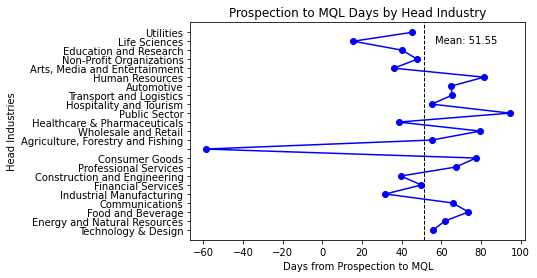

In [62]:
plt.plot(byind_df['Prosp to MQL'],byind_df['Industries'],'bo-')
plt.title('Prospection to MQL Days by Head Industry')
plt.xlabel('Days from Prospection to MQL')
plt.ylabel('Head Industries')
plt.axvline(byind_df['Prosp to MQL'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(byind_df['Prosp to MQL'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(byind_df['Prosp to MQL'].mean()))
plt.show()

Prospection to MQL by Country

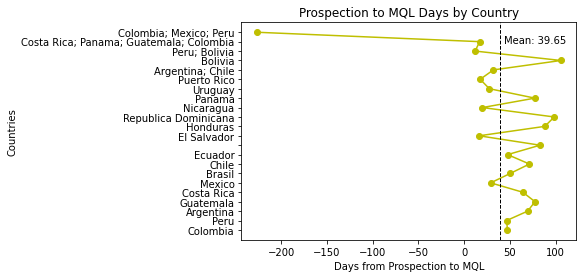

In [63]:
plt.plot(bycountry_df['Prosp to MQL'],bycountry_df['Country HB'],'yo-')
plt.title('Prospection to MQL Days by Country')
plt.xlabel('Days from Prospection to MQL')
plt.ylabel('Countries')
plt.axvline(bycountry_df['Prosp to MQL'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(bycountry_df['Prosp to MQL'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(bycountry_df['Prosp to MQL'].mean()))
plt.show()

Prospection to SQL by Industry

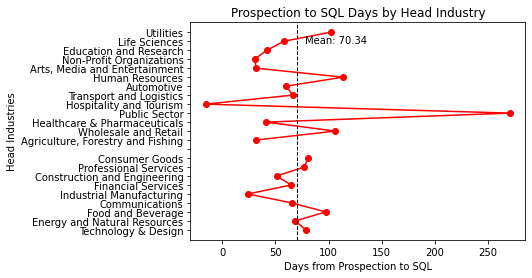

In [64]:
plt.plot(byind_df['Prosp to SQL'],byind_df['Industries'],'ro-')
plt.title('Prospection to SQL Days by Head Industry')
plt.xlabel('Days from Prospection to SQL')
plt.ylabel('Head Industries')
plt.axvline(byind_df['Prosp to SQL'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(byind_df['Prosp to SQL'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(byind_df['Prosp to SQL'].mean()))
plt.show()

Prospection to Opportunity by Industry

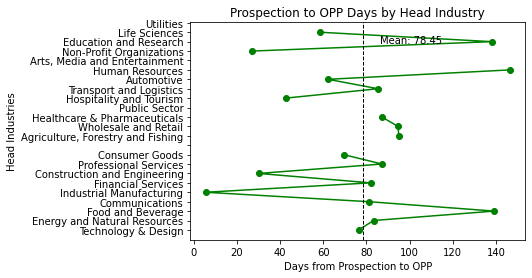

In [65]:
plt.plot(byind_df['Prosp to OPP'],byind_df['Industries'],'go-')
plt.title('Prospection to OPP Days by Head Industry')
plt.xlabel('Days from Prospection to OPP')
plt.ylabel('Head Industries')
plt.axvline(byind_df['Prosp to OPP'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(byind_df['Prosp to OPP'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(byind_df['Prosp to OPP'].mean()))
plt.show()

## Visualizations for Brasil

Now just for Brasil

In [ ]:
matched_df_br = matched_df[(matched_df["Country HB"].isin(['Brasil']))]
byind_df_br = matched_df_br[['Head Industry New','MQL to SQL','SQL to OPP','MQL to Opportunity','Prosp to MQL','Prosp to SQL','Prosp to OPP']].groupby(pd.Grouper(key='Head Industry New')).mean()
byind_df_br['Industries'] = byind_df_br.index
byind_df_sort_br = byind_df_br.sort_index
byind_df_br

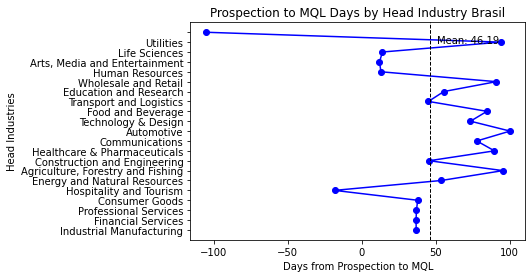

In [59]:
plt.plot(byind_df_br['Prosp to MQL'],byind_df_br['Industries'],'bo-')
plt.title('Prospection to MQL Days by Head Industry Brasil')
plt.xlabel('Days from Prospection to MQL')
plt.ylabel('Head Industries')
plt.axvline(byind_df_br['Prosp to MQL'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(byind_df_br['Prosp to MQL'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(byind_df_br['Prosp to MQL'].mean()))
plt.show()

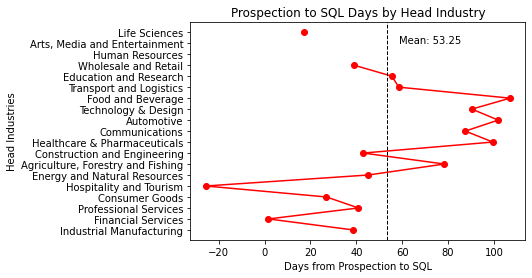

In [60]:
plt.plot(byind_df_br['Prosp to SQL'],byind_df_br['Industries'],'ro-')
plt.title('Prospection to SQL Days by Head Industry')
plt.xlabel('Days from Prospection to SQL')
plt.ylabel('Head Industries')
plt.axvline(byind_df_br['Prosp to SQL'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(byind_df_br['Prosp to SQL'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(byind_df_br['Prosp to SQL'].mean()))
plt.show()

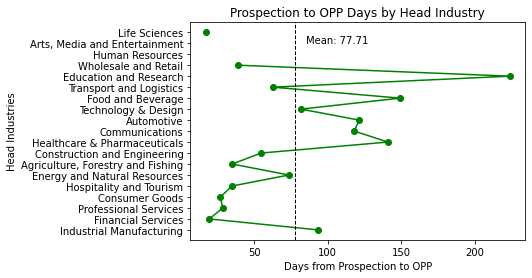

In [61]:
plt.plot(byind_df_br['Prosp to OPP'],byind_df_br['Industries'],'go-')
plt.title('Prospection to OPP Days by Head Industry')
plt.xlabel('Days from Prospection to OPP')
plt.ylabel('Head Industries')
plt.axvline(byind_df_br['Prosp to OPP'].mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(byind_df_br['Prosp to OPP'].mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(byind_df_br['Prosp to OPP'].mean()))
plt.show()

## Prescriptive Analysis

1. If we have conversion time from Head Industries, and at the end of the year we don't convert much. It's better to focus on industries that have a lower conversion time.

In [37]:
#Top 5 Industries that turn into a MQL from Prospection
byind_df.head(5).sort_values('Prosp to MQL')
#Top 5 Industries that turn into a SQL from Prospection
byind_df.head(5).sort_values('Prosp to SQL')
#Top 5 Industries that turn into a OPP from Prospection
byind_df.head(5).sort_values('Prosp to OPP')

,Prosp to MQL,Prosp to SQL,Prosp to OPP,Industries
Head Industry New,,,,
Industrial Manufacturing,31.862069,24.142857,5.500000,Industrial Manufacturing
Technology & Design,55.935252,78.523077,76.476190,Technology & Design
Communications,65.722222,65.555556,81.000000,Communications
Energy and Natural Resources,61.927835,68.730769,83.259259,Energy and Natural Resources
Food and Beverage,73.711538,97.379310,139.142857,Food and Beverage


2. Getting the sub-industries from the results

In [49]:
bysubinds_df = matched_df[['Industry HB','Head Industry New','MQL to SQL','SQL to OPP','MQL to Opportunity','Prosp to MQL','Prosp to SQL','Prosp to OPP']].groupby(pd.Grouper(key='Industry HB')).mean()
bysubinds_df['Sub Industries'] = bysubinds_df.index
bysubinds_df['Head Industry'] = bysubinds_df["Sub Industries"].map(ind_dict)

In [53]:
results_subinds = bysubinds_df[(bysubinds_df['Head Industry'].isin(['Industrial Manufacturing','Technology & Design','Communications','Energy and Natural Resources','Food and Beverage']))]
results_subinds.sort_values('Prosp to SQL')

,Prosp to MQL,Prosp to SQL,Prosp to OPP,Sub Industries,Head Industry
Industry HB,,,,,
Industrial Automation,-8.166667,-44.666667,-166.000000,Industrial Automation,Industrial Manufacturing
Computer & Network Security,54.000000,12.000000,NaN,Computer & Network Security,Technology & Design
Plastics,41.666667,12.000000,12.000000,Plastics,Industrial Manufacturing
Paper & Forest Products,16.250000,16.500000,NaN,Paper & Forest Products,Industrial Manufacturing
Furniture,3.000000,18.500000,NaN,Furniture,Industrial Manufacturing
Computer Software,52.937500,37.142857,19.000000,Computer Software,Technology & Design
Oil & Energy,59.088235,42.500000,39.571429,Oil & Energy,Energy and Natural Resources
Electrical/Electronic Manufacturing,68.555556,65.000000,46.750000,Electrical/Electronic Manufacturing,Industrial Manufacturing
Telecommunications,65.722222,65.555556,81.000000,Telecommunications,Communications


Results on Better Industries to focus on: 
- Computer & Network Security	
- Plastics
- Computer Software
- Oil & Energy
- Electrical/Electronic Manufacturing

### For Brasil

In [56]:
byind_df_br.head(5).sort_values('Prosp to MQL')

,Prosp to MQL,Prosp to SQL,Prosp to OPP,Industries
Head Industry New,,,,
Hospitality and Tourism,-18.400000,-25.666667,35.0,Hospitality and Tourism
Financial Services,36.736842,1.714286,19.5,Financial Services
Industrial Manufacturing,36.833333,38.571429,93.5,Industrial Manufacturing
Professional Services,37.000000,40.900000,28.6,Professional Services
Consumer Goods,37.846154,27.000000,27.0,Consumer Goods


In [57]:
bysubinds_df_br = matched_df_br[['Industry HB','Head Industry New','MQL to SQL','SQL to OPP','MQL to Opportunity','Prosp to MQL','Prosp to SQL','Prosp to OPP']].groupby(pd.Grouper(key='Industry HB')).mean()
bysubinds_df_br['Sub Industries'] = bysubinds_df_br.index
bysubinds_df_br['Head Industry'] = bysubinds_df_br["Sub Industries"].map(ind_dict)

In [58]:
results_subinds_br = bysubinds_df_br[(bysubinds_df_br['Head Industry'].isin(['Hospitality and Tourism','Financial Services','Industrial Manufacturing','Professional Services','Consumer Goods']))]
results_subinds_br.sort_values('Prosp to SQL')

,Prosp to MQL,Prosp to SQL,Prosp to OPP,Sub Industries,Head Industry
Industry HB,,,,,
Banking,-76.000000,-114.500000,23.000000,Banking,Financial Services
"Leisure, Travel & Tourism",-26.000000,-25.666667,35.000000,"Leisure, Travel & Tourism",Hospitality and Tourism
Industrial Automation,15.750000,16.000000,NaN,Industrial Automation,Industrial Manufacturing
Paper & Forest Products,12.000000,16.500000,NaN,Paper & Forest Products,Industrial Manufacturing
Furniture,9.000000,18.000000,NaN,Furniture,Industrial Manufacturing
Law Practice,14.333333,21.000000,NaN,Law Practice,Professional Services
Legal Services,14.000000,23.000000,NaN,Legal Services,Professional Services
Facilities Services,125.000000,24.000000,NaN,Facilities Services,Professional Services
Outsourcing/Offshoring,20.666667,24.333333,22.500000,Outsourcing/Offshoring,Professional Services


Results on Better Industries to focus on for Brasil:
- Banking		
- Leisure, Travel & Tourism	
- Outsourcing/Offshoring	
- Consumer Goods	
- Marketing and Advertising
- Financial Services
- Electrical/Electronic Manufacturing